# NY Crime

I have a dataset with information on crime across many different areas in New York state. I will attempt to build a model that can predict property crime in New York State. I will begin by iimporting and cleaning the data.

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import cross_val_score

In [2]:
crime = pd.read_csv('nycrime.csv')
display(crime.head())

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


It seems the column names have gotten mixed up in the dataframe, I'll have to correct that.

In [3]:
column = pd.Series(crime.iloc[3]).values

In [4]:
crime = crime.drop(crime.index[[0,1,2,3,352,353,354]])
crime.columns = column
crime.reset_index(inplace=True)
display(crime.head())

,index,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
1,5,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
2,6,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
3,7,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,8,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


So I have 13 columns of variables, all of which of explanitory by their column names. 


# Feature Creation and Selection


From here, I will can begin feature selection for the model. I'll create a dataframe to hold all my possible features.

In [5]:
features = pd.DataFrame()

In [6]:
#Property Crime
features['Property_Crime'] = crime['Property\ncrime'].str.replace(',','')
for i in range(len(crime['Property\ncrime'])):
    features['Property_Crime'][i] = int(features['Property_Crime'][i])
#Violent Crime
features['Violent_Crime'] = crime['Violent\ncrime'].str.replace(',','')
for i in range(len(crime['Violent\ncrime'])):
    features['Violent_Crime'][i] = int(features['Violent_Crime'][i])
#Population
features['Population'] = crime['Population'].str.replace(',','')
for i in range(len(crime['Population'])):
    features['Population'][i] = int(features['Population'][i])
#Population squared
features['Pop_Squared'] = features['Population']
for i in range(len(features['Population'])):
    features['Pop_Squared'][i] = int(features['Pop_Squared'][i])*int(features['Pop_Squared'][i])
#Murder Total
features['Murder'] = crime['Murder and\nnonnegligent\nmanslaughter'].str.replace(',','')
for i in range(len(crime['Murder and\nnonnegligent\nmanslaughter'])):
    features['Murder'][i] = int(features['Murder'][i])
#Robbery Total
features['Robbery'] = crime['Robbery'].str.replace(',','')
for i in range(len(crime['Robbery'])):
    features['Robbery'][i] = int(features['Robbery'][i])
#Assault Total
features['Assault'] = crime['Aggravated\nassault'].str.replace(',','')
for i in range(len(crime['Aggravated\nassault'])):
    features['Assault'][i] = int(features['Assault'][i])

#Murder as a Categorical
features['Murder_Cat'] = crime['Murder and\nnonnegligent\nmanslaughter'].str.replace(',','')
for i in range(len(crime['Murder and\nnonnegligent\nmanslaughter'])):
    features['Murder_Cat'][i] = int(features['Murder_Cat'][i])
    if features['Murder_Cat'][i] == 0:
        features['Murder_Cat'][i] = 0
    else:
        features['Murder_Cat'][i] = 1
#Robbery as a Categorical
features['Robbery_Cat'] = crime['Robbery'].str.replace(',','')
for i in range(len(crime['Robbery'])):
    features['Robbery_Cat'][i] = int(features['Robbery_Cat'][i])
    if features['Robbery_Cat'][i] == 0:
        features['Robbery_Cat'][i] = 0
    else:
        features['Robbery_Cat'][i] = 1
#Assault as a Categorical
features['Assault_Cat'] = crime['Aggravated\nassault'].str.replace(',','')
for i in range(len(crime['Aggravated\nassault'])):
    features['Assault_Cat'][i] = int(features['Assault_Cat'][i])
    if features['Assault_Cat'][i] == 0:
        features['Assault_Cat'][i] = 0
    else:
        features['Assault_Cat'][i] = 1
        
features = features.apply(pd.to_numeric)

#City
features['City'] = crime['City']

In [7]:
display(features.head())

,Property_Crime,Violent_Crime,Population,Pop_Squared,Murder,Robbery,Assault,Murder_Cat,Robbery_Cat,Assault_Cat,City
0,12,0,1861,3463321,0,0,0,0,0,0,Adams Village
1,24,3,2577,6640929,0,0,3,0,0,1,Addison Town and Village
2,16,3,2846,8099716,0,0,3,0,0,1,Akron Village
3,4090,791,97956,9595377936,8,227,526,1,1,1,Albany
4,223,23,6388,40806544,0,4,16,0,1,1,Albion Village


In [8]:
display(features.describe())

,Property_Crime,Violent_Crime,Population,Pop_Squared,Murder,Robbery,Assault,Murder_Cat,Robbery_Cat,Assault_Cat
count,348.000000,348.000000,3.480000e+02,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,792.606322,201.594828,4.003763e+04,2.035547e+11,1.566092,72.902299,121.261494,0.140805,0.600575,0.810345
std,7659.724746,2815.268504,4.500374e+05,3.778876e+12,18.303673,1031.032873,1706.131730,0.348321,0.490486,0.392593
min,0.000000,0.000000,5.260000e+02,2.766760e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.500000,2.000000,3.003000e+03,9.018117e+06,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,112.500000,6.000000,7.233500e+03,5.232568e+07,0.000000,1.000000,4.000000,0.000000,1.000000,1.000000
75%,341.000000,22.000000,1.842750e+04,3.397536e+08,0.000000,5.000000,14.000000,0.000000,1.000000,1.000000
max,141971.000000,52384.000000,8.396126e+06,7.049493e+13,335.000000,19170.000000,31767.000000,1.000000,1.000000,1.000000


There seems to be a huge outlier value, I'll inspect it a possibly delete it.

In [9]:
 display(features[features['Property_Crime']==features['Property_Crime'].max()])

,Property_Crime,Violent_Crime,Population,Pop_Squared,Murder,Robbery,Assault,Murder_Cat,Robbery_Cat,Assault_Cat,City
216,141971,52384,8396126,70494931807876,335,19170,31767,1,1,1,New York


In [10]:
features = features.drop(features.index[216])

The outlier is New York City, which makes sense. It is the most densely populated area in New York by a wide margin and thus has a great amount of crime comparitively. I drop the New York City row.


## Creating Model

I'll create a model using all the features I have created 

In [11]:
regr = linear_model.LinearRegression()
target = features['Property_Crime'].values.reshape(-1, 1)
data = features[['Violent_Crime','Population','Pop_Squared','Murder','Robbery',
                 'Assault','Murder_Cat','Robbery_Cat','Assault_Cat']]
regr.fit(data, target)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(data, target))


Coefficients: 
 [[ 4.34937376e+01  1.94233982e-02 -7.02930775e-08  1.15688112e+01
  -4.13579468e+01 -4.31223081e+01 -1.57601289e+02  2.42233918e+01
  -3.92236026e+00]]

Intercept: 
 [-43.51970372]

R-squared:
0.9589964583433404


My model has a fairly high R Squared value, indicating it explains about 96% of the variance of the data. Now I need to improve it.

# Validating The Model

I now want to test my model and see how well it does outside of the training data. To do this, I will use similarly collected crime data for the state of Conneticutt and see if I still accurately predict property crime.

In [12]:
crime2 = pd.read_excel('ctcrime.xls')

In [13]:
#display(crime2)

In [14]:
column = pd.Series(crime2.iloc[3]).values

In [15]:
crime2 = crime2.drop(crime2.index[[0,1,2,3,96,97]])
crime2.columns = column
crime2.reset_index(inplace=True)
crime2.drop(crime2.columns[1], axis=1)
display(crime2.head())

,index,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,4,Ansonia,19128,33,0,5,NaN,16,12,393,59,284,50,1
1,5,Avon,18325,12,0,8,NaN,3,1,143,20,117,6,1
2,6,Berlin,20657,14,0,5,NaN,4,5,277,41,225,11,1
3,7,Bethel,19338,3,0,2,NaN,0,1,180,31,143,6,2
4,8,Bloomfield,20637,46,1,9,NaN,10,26,464,51,391,22,1


## Creating Test Data

Now that I have imported and cleaned the data, I will construct another dataframe for it's possible features.

In [16]:
features2 = pd.DataFrame()

In [17]:
#Property Crime
features2['Property_Crime'] = crime2['Property\ncrime']
#Violent Crime
features2['Violent_Crime'] = crime2['Violent\ncrime']
#Population
features2['Population'] = crime2['Population']
#Population squared
features2['Pop_Squared'] = features2['Population']*features2['Population']
#Murder Total
features2['Murder'] = crime2['Murder and\nnonnegligent\nmanslaughter']
#Robbery Total
features2['Robbery'] = crime2['Robbery']
#Assault Total
features2['Assault'] = crime2['Aggravated\nassault']

#Murder as a Categorical
features2['Murder_Cat'] = crime2['Murder and\nnonnegligent\nmanslaughter']
for i in range(len(crime2['Murder and\nnonnegligent\nmanslaughter'])):
    if features2['Murder_Cat'][i] == 0:
        features2['Murder_Cat'][i] = 0
    else:
        features2['Murder_Cat'][i] = 1
#Robbery as a Categorical
features2['Robbery_Cat'] = crime2['Robbery']
for i in range(len(crime2['Robbery'])):
    if features2['Robbery_Cat'][i] == 0:
        features2['Robbery_Cat'][i] = 0
    else:
        features2['Robbery_Cat'][i] = 0
#Assault as a Categorical
features2['Assault_Cat'] = crime2['Aggravated\nassault']
for i in range(len(crime2['Aggravated\nassault'])):
    if features2['Assault_Cat'][i] == 0:
        features2['Assault_Cat'][i] = 0
    else:
        features2['Assault_Cat'][i] = 1

features2 = features2.apply(pd.to_numeric)

In [18]:
#City
features2['City'] = crime2['City']

In [19]:
display(features2.describe())

,Property_Crime,Violent_Crime,Population,Pop_Squared,Murder,Robbery,Assault,Murder_Cat,Robbery_Cat,Assault_Cat
count,92.000000,92.000000,92.000000,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.0,92.000000
mean,712.413043,95.597826,33247.043478,1.951959e+09,0.869565,37.673913,49.739130,0.206522,0.0,0.891304
std,1063.010624,273.681658,29255.704662,3.863528e+09,3.325616,117.276428,143.908462,0.407027,0.0,0.312963
min,3.000000,0.000000,519.000000,2.693610e+05,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,154.250000,6.000000,14349.250000,2.059021e+08,0.000000,0.750000,2.000000,0.000000,0.0,1.000000
50%,323.000000,17.000000,23030.000000,5.307665e+08,0.000000,6.000000,7.000000,0.000000,0.0,1.000000
75%,792.000000,45.250000,41249.250000,1.703253e+09,0.000000,15.250000,25.000000,0.000000,0.0,1.000000
max,6068.000000,1643.000000,147076.000000,2.163135e+10,23.000000,770.000000,840.000000,1.000000,0.0,1.000000


In [20]:
#display(features2)

Now that the features are all set-up, it's time to actually see how my model preforms outside the training data.

In [21]:
target2 = features2['Property_Crime'].values.reshape(-1,1)
data2 = features2[['Violent_Crime','Population','Pop_Squared','Murder','Robbery',
                 'Assault','Murder_Cat','Robbery_Cat','Assault_Cat']]

print('R Squared for CT crime data:\n')
print(regr.score(data2, target2))

R Squared for CT crime data:

0.7687598847685635


So my model was able to predict Conneticut Crime with an accuracy of about 77%. While this is not as accurate as I would have hoped, it is still fairly accurate and shows my model is on the right track.

## Improving the Model

The best way to improve my model is improve my feature selection.

In [22]:
#Create the same model using OLS
linear_formula = 'Property_Crime~Violent_Crime+Population+Pop_Squared+Murder+Robbery+Assault+Murder_Cat+Robbery_Cat+Assault_Cat'
model = smf.ols(linear_formula, data=features).fit()

In [23]:
print('Parameter Values:\n')
print(model.params)
print('\nParamter P-Values:\n')
print(model.pvalues)
print('\nR-Squared for Training Data:\n')
print(model.rsquared)

Parameter Values:

Intercept       -4.351969e+01
Violent_Crime    4.349374e+01
Population       1.942340e-02
Pop_Squared     -7.029308e-08
Murder           1.156881e+01
Robbery         -4.135795e+01
Assault         -4.312231e+01
Murder_Cat      -1.576013e+02
Robbery_Cat      2.422339e+01
Assault_Cat     -3.922360e+00
dtype: float64

Paramter P-Values:

Intercept        1.032476e-01
Violent_Crime    1.208325e-19
Population       1.959825e-43
Pop_Squared      1.052929e-12
Murder           5.162902e-01
Robbery          1.919033e-19
Assault          6.398689e-17
Murder_Cat       3.430827e-04
Robbery_Cat      3.986603e-01
Assault_Cat      9.039517e-01
dtype: float64

R-Squared for Training Data:

0.9589964583433395


In [24]:
print('Confidence Interval for each Parameter:')
display(model.conf_int())

Confidence Interval for each Parameter:


,0,1
Intercept,-9.591757e+01,8.878201e+00
Violent_Crime,3.463604e+01,5.235143e+01
Population,1.704197e-02,2.180483e-02
Pop_Squared,-8.896288e-08,-5.162329e-08
Murder,-2.345365e+01,4.659128e+01
Robbery,-4.983388e+01,-3.288202e+01
Assault,-5.274255e+01,-3.350207e+01
Murder_Cat,-2.432991e+02,-7.190349e+01
Robbery_Cat,-3.215889e+01,8.060568e+01
Assault_Cat,-6.781170e+01,5.996698e+01


Looking the p-values of my parameters, the Murder, Robbery_Cat, and Assault_Cat all seem extraneous. Additionally, they both have confidence intervals containing 0, further indicating that they are not useful to my model. I'll make a new model that doesn't use these features

In [46]:
regrv2 = linear_model.LinearRegression()
target = features['Property_Crime'].values.reshape(-1, 1)
datav2 = features[['Violent_Crime','Population','Pop_Squared','Robbery',
                 'Assault','Murder_Cat']]
regrv2.fit(datav2, target)

print('\nCoefficients: \n', regrv2.coef_)
print('\nIntercept: \n', regrv2.intercept_)
print('\nR-squared:')
print(regrv2.score(datav2, target))


Coefficients: 
 [[ 4.57081045e+01  1.97221435e-02 -7.27773188e-08 -4.30629040e+01
  -4.55895807e+01 -1.46893331e+02]]

Intercept: 
 [-37.74091296]

R-squared:
0.9588724685342166


In [47]:
data2 = features2[['Violent_Crime','Population','Pop_Squared','Robbery','Assault','Murder_Cat']]
target2 = features2['Property_Crime']

print('R Squared for CT crime data:\n')
print(regrv2.score(data2, target2))

R Squared for CT crime data:

0.7437761090858191


## Improving Features

Can I select better features? Are any of my features extraneous?

I begin to check first by checking the p-value of all the features I've used. 

In [27]:
#Create model to check P-values
linear_formula = 'Property_Crime~Violent_Crime+Population+Pop_Squared+Robbery+Assault+Murder_Cat'
modelv2 = smf.ols(linear_formula, data=features).fit()
print('Regrssion P-Values:')
print(modelv2.pvalues)

Regrssion P-Values:
Intercept        1.656899e-02
Violent_Crime    1.269147e-37
Population       3.168652e-51
Pop_Squared      1.589882e-14
Robbery          4.565653e-29
Assault          4.940219e-34
Murder_Cat       4.266776e-04
dtype: float64


The p-value of Robbery as a categorial is very high, so it would be best to remove it. 

Next, I can check how the features interact and corrate. I'll start by graphing them in a scatter plot, then graph a heatmap of there correlation to one another.

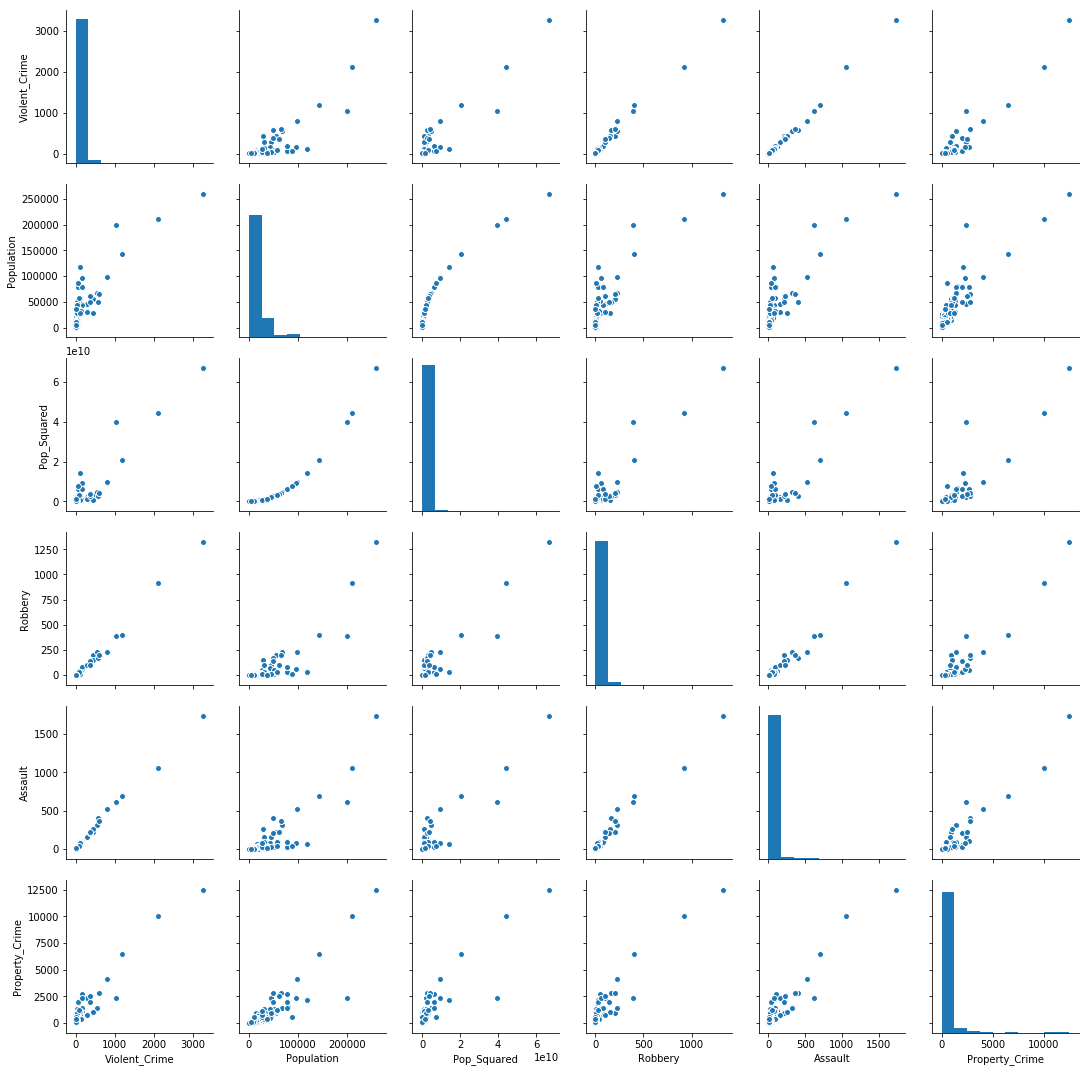

In [28]:
cont = ['Violent_Crime','Population','Pop_Squared','Robbery','Assault','Property_Crime']
sns.pairplot(features[cont])
plt.show()

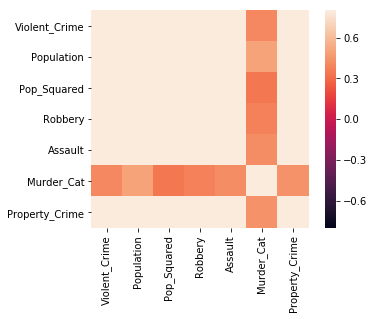

In [29]:
fcorr = features[['Violent_Crime','Population','Pop_Squared','Robbery',
                 'Assault','Murder_Cat','Property_Crime']].corr()


# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

All features appear to have a close to linear relationship with Property Crime. Unfortunately, the nature of the features and the data itself means that all the features have very strong correlation with each other as well. 

In [38]:
score = cross_val_score(regr,data,target,cv=15)
print(score)
print("\nCV for Initial Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[ 0.91597258  0.99787684  0.78566877  0.61883844  0.82644344  0.81434403
  0.4107114   0.39192683  0.80189342  0.62584856  0.41645094  0.96187465
  0.9518715   0.97600522 -0.32017054]

CV for Initial Model: 0.68 (+/- 0.67)


In [48]:
score = cross_val_score(regrv2,datav2,target,cv=15)
print(score)
print("\nCV for Revised Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[ 0.92276057  0.99775081  0.79246145  0.60848089  0.82601238  0.81996255
  0.52721106  0.4144449   0.79656053  0.63160187  0.42185644  0.96425464
  0.94911256  0.98196379 -0.27194358]

CV for Revised Model: 0.69 (+/- 0.64)


The accuracy for the revised model is slightly better, but there is still much to do for this model. 